# Kolmogorov complexity of CNN kernels
Author: Guillermo TOYOS MARFURT

In [1]:
#required imports
import torch, torchvision
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
import gzip
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import copy
import os

### Load dataset

Label: tensor(4)


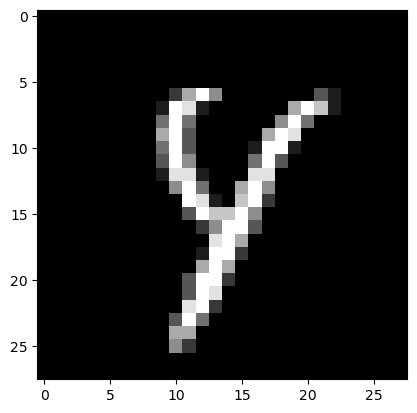

In [2]:
image_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                ])

#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/', 
                                          train=False, 
                                          download=True,
                                          transform=image_transform)

#data loaders
batch_size_train = 64 # We use a small batch size here for training
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1024, 
                                          shuffle=True)

# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0][0]
# show the data
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[0]))

### Build the network

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input channel 1, output channel 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        #input channel 10, output channel 20
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        #dropout layer
        self.conv2_drop = nn.Dropout2d()
        #fully connected layer
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
class MobileNetV1(nn.Module):
    def __init__(self, ch_in, n_classes):
        super(MobileNetV1, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                # pw
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_bn(ch_in, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

### Define training algorithm

In [5]:
## create model and optimizer
learning_rate = 0.01
momentum = 0.5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device) # send model to GPU
#model = MobileNetV1(1, 10).to(device) # send model to GPU
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [6]:
#get weights
def get_weights(model):
    weights = []
    for param in model.parameters():
        if param.data.dim() == 4:
            weights.append(param.data.detach().cpu().numpy())
        #weights.append(param.data.detach().cpu().numpy())
    return weights

In [7]:
### Train and test errors
train_errors = []
test_errors = []
acc = []
net_ratio = []
for i in range(len(get_weights(model))):
    net_ratio.append([])

##define train function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
        if batch_idx % 100 == 0:
            train_errors.append(loss.detach().cpu())
            model_copy = copy.deepcopy(model)
            for param in model_copy.parameters():
                param.data[param.data.abs() < 0.05] = 0
            test(model_copy, device, test_loader)

##define test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_errors.append(test_loss)
    acc.append(correct/len(test_loader.dataset))
    for i,w in enumerate(get_weights(model)):
        f = gzip.GzipFile("compress.gz", "w")
        np.save(file=f, arr=w)
        f.close()
        np.save('normal.npy', w)
        compressed_size = os.path.getsize('compress.gz')
        normal_size = os.path.getsize('normal.npy')
        net_ratio[i].append(compressed_size/normal_size)
        
        os.remove('compress.gz')
        os.remove('normal.npy')

    #print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #    test_loss, correct, len(test_loader.dataset),
    #    100. * correct / len(test_loader.dataset)))

In [8]:
num_epoch = 50
for epoch in range(1, num_epoch + 1):
        train(model, device, train_loader, optimizer, epoch)
        #test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

KeyboardInterrupt: 

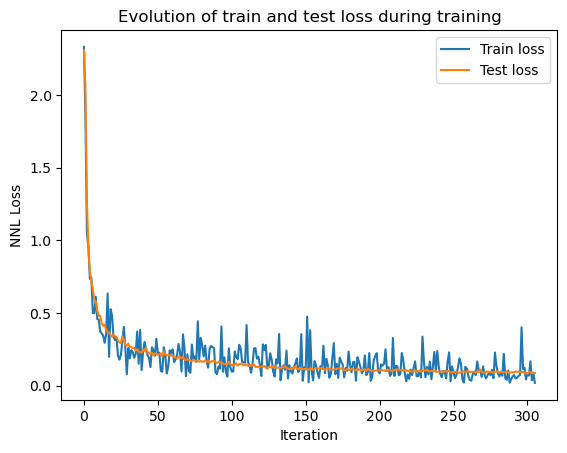

In [9]:
#plot the train and test errors
type(train_errors)
plt.plot(train_errors, label='Train loss')
plt.plot(test_errors, label='Test loss')
plt.xlabel('Iteration')
plt.ylabel('NNL Loss')
plt.title('Evolution of train and test loss during training')
plt.legend()
plt.show()


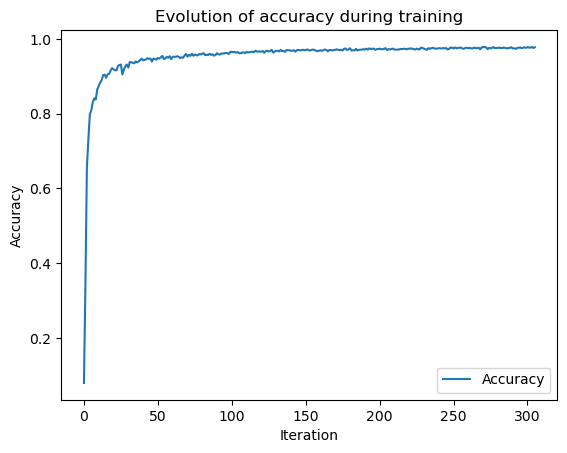

In [10]:
#PLOT ACC  
plt.plot(acc, label='Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Evolution of accuracy during training')
plt.legend()
plt.show()


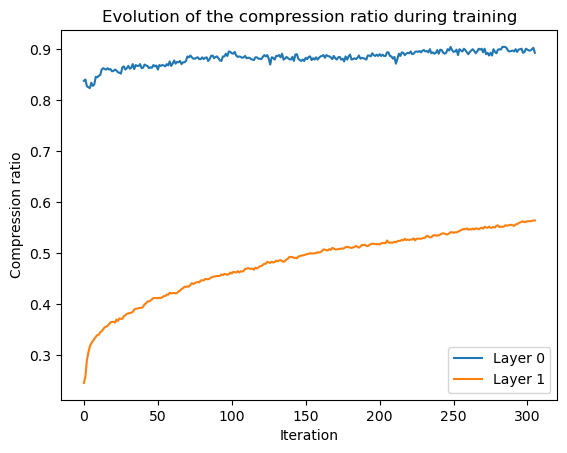

In [11]:
#plot each sublist of net_ratio
for i in range(len(net_ratio)):
    plt.plot(net_ratio[i], label='Layer {}'.format(i))

plt.xlabel('Iteration')
plt.ylabel('Compression ratio')
plt.title('Evolution of the compression ratio during training')
plt.legend()
plt.show()

In [12]:
get_weights(model)[1]

array([[[[ 4.50627506e-02,  4.10650037e-02, -2.26644091e-02,
           1.15749035e-02, -9.75458324e-02],
         [ 5.85005037e-04, -5.10862581e-02,  5.30243367e-02,
           1.40669018e-01,  3.14068161e-02],
         [-6.84040040e-02, -6.88043013e-02, -1.49841523e-02,
          -1.57688465e-02, -3.93068716e-02],
         [-3.70342471e-02, -1.22900762e-01, -7.14368895e-02,
          -5.18227555e-02, -7.44250566e-02],
         [-2.80508585e-02,  2.50941725e-03,  5.02386801e-02,
          -1.67879704e-02, -1.69195812e-02]],

        [[-1.11259826e-01,  3.22141452e-04, -7.94731826e-02,
          -8.31994563e-02,  1.12640476e-02],
         [-4.52715270e-02,  1.28719077e-01,  1.00125894e-01,
           1.35384053e-02, -2.03406494e-02],
         [ 2.22504213e-01, -4.05609757e-02, -1.60561278e-02,
          -1.36829346e-01, -2.63051033e-01],
         [ 2.95720220e-01,  4.72345240e-02, -6.41818047e-02,
          -1.35005061e-02, -8.26230049e-02],
         [ 2.40352422e-01,  1.12263814e-01, 

In [16]:
#copy model
import copy
model_copy = copy.deepcopy(model)


In [21]:
#remove all weights smaller than 0.1 and round floats to 3 decimals
for param in model_copy.parameters():
    param.data[param.data.abs() < 0.1] = 0
    param.data = torch.round(param.data * 1000) / 1000

In [22]:
get_weights(model_copy)[1]

array([[[[ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.141     ,
           0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ],
         [ 0.        , -0.123     ,  0.        ,  0.        ,
           0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ]],

        [[-0.11100001,  0.        ,  0.        ,  0.        ,
           0.        ],
         [ 0.        ,  0.12900001,  0.1       ,  0.        ,
           0.        ],
         [ 0.223     ,  0.        ,  0.        , -0.13700001,
          -0.263     ],
         [ 0.296     ,  0.        ,  0.        ,  0.        ,
           0.        ],
         [ 0.24000001,  0.112     ,  0.        ,  0.        ,
           0.        ]],

        [[ 0.        ,  0.        ,  0.        ,  0.        ,
           0.136     ],
         [ 0.16800001,  0.        ,  0.        ,  

In [23]:
def test2(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    #test_errors.append(test_loss)
    
    for i,w in enumerate(get_weights(model)):
        f = gzip.GzipFile("compress.gz", "w")
        np.save(file=f, arr=w)
        f.close()
        np.save('normal.npy', w)
        compressed_size = os.path.getsize('compress.gz')
        normal_size = os.path.getsize('normal.npy')
        #net_ratio[i].append(compressed_size/normal_size)
        print('Layer {} : Compression ratio = {}'.format(i, compressed_size/normal_size))
        os.remove('compress.gz')
        os.remove('normal.npy')

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [24]:
#test model
test2(model_copy, device, test_loader)

Layer 0 : Compression ratio = 0.7278368794326241
Layer 1 : Compression ratio = 0.16439785373608903

Test set: Average loss: 0.6335, Accuracy: 8620/10000 (86%)

